# Simulating long-slit spectroscopy in METIS

This notebook shows the most basic setup for long-slit spectroscopy, using a star as the source.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scopesim as sim
sim.bug_report()

# Edit this path if you have a custom install directory, otherwise comment it out.
sim.link_irdb("../../../../")

Python:
3.10.18 (main, Jun  5 2025, 13:08:10) [GCC 11.2.0]

Installed Python packages:
           anisocado: 0.3.0
         astar-utils: 0.3.3
             astropy: 6.1.7
      beautifulsoup4: 4.13.4
            docutils: 0.19
               httpx: 0.28.1
                lxml: 5.4.0
          matplotlib: 3.10.5
      more-itertools: 10.7.0
               numpy: 1.26.4
           packaging: 25.0
               pooch: 1.8.2
              pyyaml: 6.0.2
               scipy: 1.15.3
            scopesim: 0.10.0
       scopesim_data: could not be loaded.
  scopesim_templates: 0.6.2
         skycalc-ipy: 0.5.3
             synphot: 1.6.0
                tqdm: 4.67.1

Installed IRDB packages:
  Armazones: 2023-07-11
        ELT: 2025-06-30
      METIS: 2025-06-30

Operating System info:
   System: Linux
  Release: 6.12.13-200.fc41.aarch64
  Version: #1 SMP PREEMPT_DYNAMIC Sat Feb  8 20:30:50 UTC 2025
  Machine: aarch64


If you haven't got the instrument packages yet, uncomment the following cell.

In [ ]:
# sim.download_packages(["METIS", "ELT", "Armazones"])

Set up the instrument in lss_l mode:

In [2]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["lss_l"])

In [3]:
metis = sim.OpticalTrain(cmd)

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:163: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  fov = thetrace.fov_grid()

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()



The source is a star with Vega spectrum and apparent brightness of 12 mag.

In [4]:
src = sim.source.source_templates.star(flux=12)

In [5]:
metis.observe(src, update=True)
result = metis.readout(detector_readout_mode="auto", exptime=1)[0]

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()



 FOV effects:   0%|          | 0/2 [00:00<?, ?it/s]

astar.scopesim.effects.psfs - Interpolating PSF onto (2600, 15, 512) cube


 PSF slices:   0%|          | 0/2600 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane - No BUNIT found in added HDU.
astar.scopesim.effects.electronic - Detector mode set to slow
astar.scopesim.effects.electronic - Requested exposure time: 1.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 4.324 s
astar.scopesim.effects.electronic - WARNING: DIT = 1.000 s < MINDIT = 1.300 s
astar.scopesim.effects.electronic - WARNING: The requested exposure time is below MINDIT. Please select a longer exptime.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 1.300 s, NDIT = 1
astar.scopesim.effects.electronic - Total exposure time: 1.300 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 2.5
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 1.300 s, NDIT = 1
astar.scopesim.effects.electronic - Total exposure time: 1.300 s


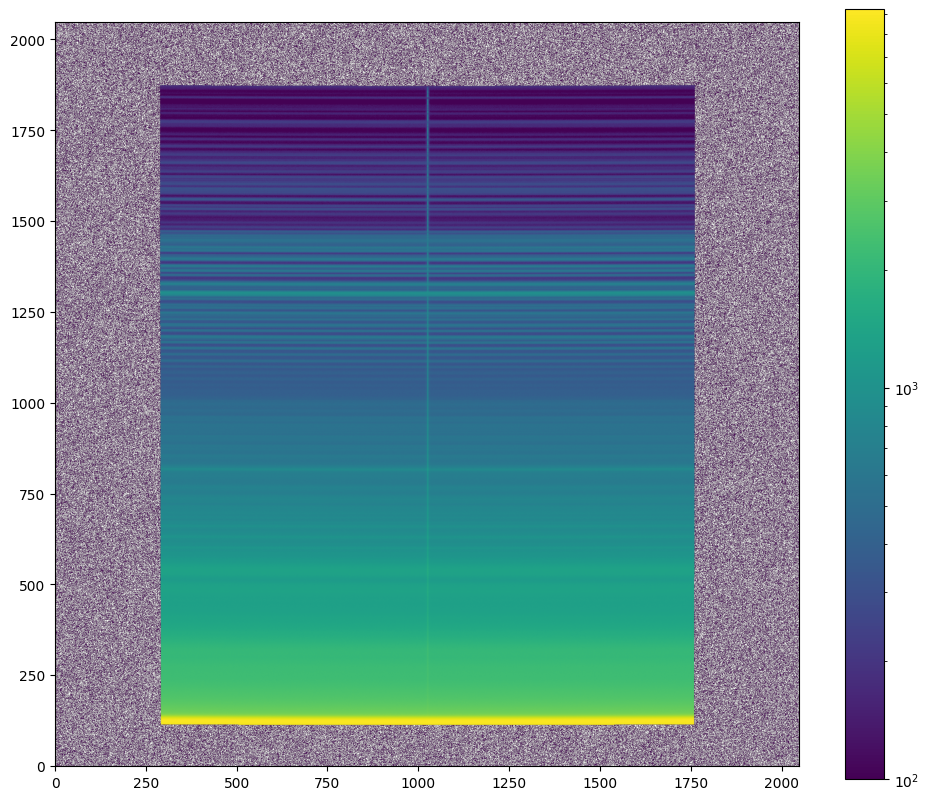

In [6]:
plt.figure(figsize=(12,10))
plt.imshow(result[1].data, origin="lower", vmin=100, norm="log")
plt.colorbar();

# Rectifying the spectrum
The default configuration for METIS applies a non-linear mapping of the two-dimensional spectrum onto the detector as determined from ray-tracing simulations of the optical system. The mapping can be reversed to obtain a rectified version of the 2D spectrum that is linear in both wavelength and spatial position and can easily be analysed. Note that this is optimistic compared to an actual data reduction process, where the mapping parameters would have to be estimated from data with some uncertainty. 

In [7]:
tracelist = metis["spectral_traces"]

In [8]:
rectified = tracelist.rectify_traces(result, -4, 4)

astar.scopesim.effects.spectral_trace_list - Full wavelength range: 2.79 .. 4.39 um
astar.scopesim.effects.spectral_trace_list - Computing interpolation functions


 Traces:   0%|          | 0/1 [00:00<?, ?it/s]

astar.scopesim.effects.spectral_trace_list_utils - Rectifying METIS LSS L
astar.scopesim.effects.spectral_trace_list_utils -    2.90 .. 4.20 um
astar.scopesim.effects.spectral_trace_list_utils -    Bin width 0.00072 um


`rectified` is again an `HDUList` with the data in the first extension. The header of this extension contains the WCS keywords needed to translate from pixels to wavelength and spatial position. 

In [9]:
from astropy.wcs import WCS
from astropy import units as u
wcs = WCS(rectified[1].header)
naxis1, naxis2 = wcs._naxis
det_wave = wcs.all_pix2world(np.arange(naxis1), 1, 0)[0] * u.Unit(wcs.wcs.cunit[0])
det_xi   = wcs.all_pix2world(1, np.arange(naxis2), 0)[1] * u.Unit(wcs.wcs.cunit[1])
det_wave = det_wave.to(u.um).value   # ensure desired units and dismiss for plotting
det_xi   = det_xi.to(u.arcsec).value

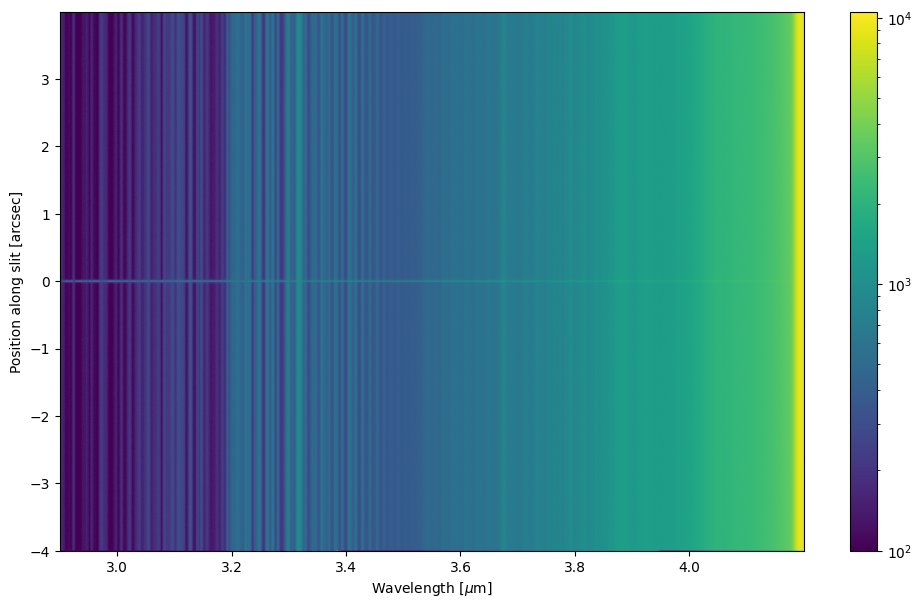

In [10]:
plt.figure(figsize=(12,7))
plt.imshow(rectified[1].data, vmin=100, norm="log",
           extent=(det_wave[0], det_wave[-1], det_xi[0], det_xi[-1]),
           origin="lower", aspect="auto")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Position along slit [arcsec]")
plt.colorbar();